In [ ]:
import pandas as pd
import numpy as np
from dataset_functions import *
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import GridSearchCV,StratifiedKFold

# Gradient Boosting

In [21]:
params = {
    'l2_regularization': [0,0.1,0.01],
    'max_features': [0.5,0.75,1.0],
    'min_samples_leaf': [50,60,70],
}

model = HistGradientBoostingClassifier(max_iter=200,validation_fraction=0.05,random_state=42,scoring="roc_auc")
scorings = ["roc_auc","accuracy","recall","precision","f1"]
best_model = GridSearchCV(estimator=model,param_grid=params,scoring=scorings,refit="roc_auc",cv=StratifiedKFold(n_splits=5,shuffle=True), return_train_score=True,verbose=1,n_jobs=-1)

In [22]:
df, target = get_dataset()
win = target['radiant_win']

Filtering Df:  (game_mode == 2 or game_mode == 22) and game_time > 0 

Dropped:  ['lobby_type', 'chat_len', 'game_mode', 'match_id_hash'] 

Dataframe Shape:  (32153, 242) 

Target shape: (32153, 6)


In [5]:
df_tt = teamstats_teamheros_transform(df.copy())
df_tt_average = team_mean_position_transform(df_tt.copy())
df_tt_weighted = team_weighted_mean_position_transform(df_tt.copy())

df_tt = feature_selection_transform(df_tt,win,0.01)
df_tt_average = feature_selection_transform(df_tt_average,win,0.01)
df_tt_weighted = feature_selection_transform(df_tt_weighted,win,0.01)

Hero Id Labels: ['r1_hero_id', 'r2_hero_id', 'r3_hero_id', 'r4_hero_id', 'r5_hero_id', 'd1_hero_id', 'd2_hero_id', 'd3_hero_id', 'd4_hero_id', 'd5_hero_id'] 

Numbers of Heros:  115 

NaN Count:  0 

Single Player Labels: ['r1_kills', 'r1_deaths', 'r1_assists', 'r1_denies', 'r1_gold', 'r1_lh', 'r1_xp', 'r1_health', 'r1_max_health', 'r1_max_mana', 'r1_level', 'r1_x', 'r1_y', 'r1_stuns', 'r1_creeps_stacked', 'r1_camps_stacked', 'r1_rune_pickups', 'r1_firstblood_claimed', 'r1_teamfight_participation', 'r1_towers_killed', 'r1_roshans_killed', 'r1_obs_placed', 'r1_sen_placed', 'r2_kills', 'r2_deaths', 'r2_assists', 'r2_denies', 'r2_gold', 'r2_lh', 'r2_xp', 'r2_health', 'r2_max_health', 'r2_max_mana', 'r2_level', 'r2_x', 'r2_y', 'r2_stuns', 'r2_creeps_stacked', 'r2_camps_stacked', 'r2_rune_pickups', 'r2_firstblood_claimed', 'r2_teamfight_participation', 'r2_towers_killed', 'r2_roshans_killed', 'r2_obs_placed', 'r2_sen_placed', 'r3_kills', 'r3_deaths', 'r3_assists', 'r3_denies', 'r3_gold', 'r

## Random forest teamstats teamheroes

In [23]:
best_model.fit(df_tt,win)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
             estimator=HistGradientBoostingClassifier(max_iter=200,
                                                      random_state=42,
                                                      scoring='roc_auc',
                                                      validation_fraction=0.05),
             n_jobs=-1,
             param_grid={'l2_regularization': [0, 0.1, 0.01],
                         'max_features': [0.5, 0.75, 1.0],
                         'min_samples_leaf': [50, 60, 70]},
             refit='roc_auc', return_train_score=True,
             scoring=['roc_auc', 'accuracy', 'recall', 'precision', 'f1'],
             verbose=1)

In [24]:
best_model.cv_results_

{'mean_fit_time': array([2.90104575, 3.59095583, 3.24713454, 3.06773939, 2.78934584,
        3.07533493, 3.01270628, 3.00516562, 3.18617029, 3.07141891,
        3.33205981, 3.23177276, 2.94986281, 3.06644692, 3.73585911,
        3.06710877, 3.29092383, 3.22528915, 2.96510568, 2.89276595,
        3.31453495, 3.95823836, 2.97795672, 3.32910171, 3.01321273,
        2.95737281, 2.95066314]),
 'std_fit_time': array([0.65348532, 0.59467055, 0.53662529, 0.40511675, 0.6308872 ,
        0.50928573, 0.64164957, 0.46395861, 0.77906094, 0.70841325,
        0.53953195, 0.31709758, 0.56203867, 0.51440687, 1.36093167,
        0.32122126, 0.97548314, 0.69311109, 0.35908291, 0.54476369,
        0.8371219 , 0.32070973, 0.66411608, 0.84159039, 0.66395373,
        0.29612243, 0.62472521]),
 'mean_score_time': array([0.28023853, 0.30358863, 0.30276775, 0.3376657 , 0.30234179,
        0.28327808, 0.24162769, 0.27948532, 0.24935713, 0.28561563,
        0.3521524 , 0.29332581, 0.28027673, 0.25660009, 0.296574

In [25]:
cv_results:dict = best_model.cv_results_

print("Best Parameters:\n",best_model.best_params_,'\n')

results = []

for scoring in scorings:

    mean_test_roc_label = f"mean_test_{scoring}"

    mean_test_score_list = cv_results[f"mean_test_{scoring}"]

    best_test_position = np.argmin(best_model.cv_results_["rank_test_roc_auc"])

    mean_train_roc_label = f"mean_train_{scoring}"

    mean_train_score_list = cv_results[f"mean_train_{scoring}"]

    results.append({"Scoring": scoring, "Mean Test Score": mean_test_score_list[best_test_position], "Mean Train Score": mean_train_score_list[best_test_position]})

df_results = pd.DataFrame(results)

df_results

Best Parameters:
 {'l2_regularization': 0.1, 'max_features': 0.75, 'min_samples_leaf': 60} 



,Scoring,Mean Test Score,Mean Train Score
0,roc_auc,0.806958,0.868584
1,accuracy,0.719995,0.779927
2,recall,0.770488,0.825447
3,precision,0.718683,0.772626
4,f1,0.743661,0.798157


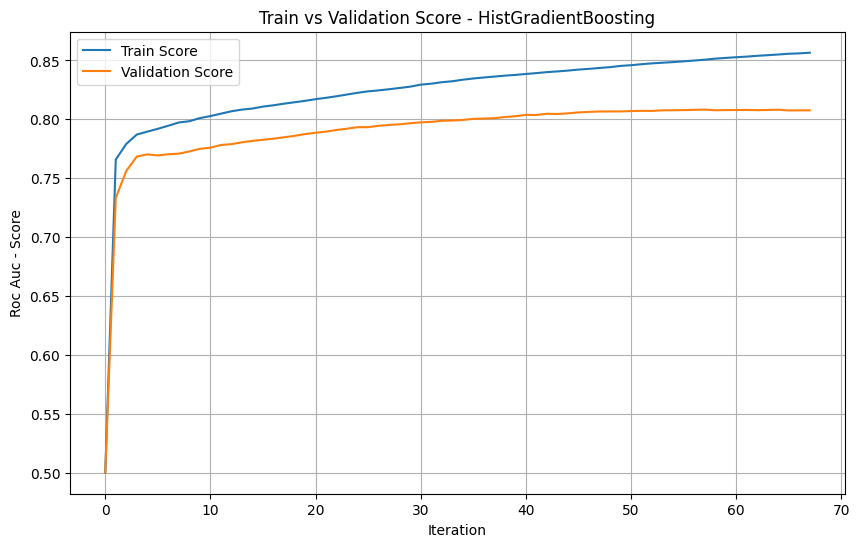

In [28]:
import matplotlib.pyplot as plt

grad = best_model.best_estimator_

plt.figure(figsize=(10, 6))
plt.plot(np.arange(0, grad.n_iter_ +1 ), grad.train_score_, label="Train Score")#, marker="o")
plt.plot(np.arange(0, grad.n_iter_ +1 ), grad.validation_score_, label="Validation Score")#, marker="s")
plt.xlabel("Iteration")
plt.ylabel("Roc Auc - Score")
plt.title("Train vs Validation Score - HistGradientBoosting")
plt.legend()
plt.grid()
plt.show()

# Random forest teamstats teamheroes + average position

In [29]:
best_model.fit(df_tt_average,win)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
             estimator=HistGradientBoostingClassifier(max_iter=200,
                                                      random_state=42,
                                                      scoring='roc_auc',
                                                      validation_fraction=0.05),
             n_jobs=-1,
             param_grid={'l2_regularization': [0, 0.1, 0.01],
                         'max_features': [0.5, 0.75, 1.0],
                         'min_samples_leaf': [50, 60, 70]},
             refit='roc_auc', return_train_score=True,
             scoring=['roc_auc', 'accuracy', 'recall', 'precision', 'f1'],
             verbose=1)

In [30]:
best_model.cv_results_

{'mean_fit_time': array([3.25013962, 2.64256706, 2.97622242, 2.7270812 , 3.02493463,
        3.01896291, 3.32483578, 2.9983356 , 3.12574244, 3.33471389,
        3.23641133, 3.39755025, 2.4213068 , 2.73431129, 3.28526583,
        2.90971937, 2.64052954, 3.4716053 , 2.81523204, 3.53046618,
        2.82797637, 2.66049819, 3.18656416, 3.75594606, 3.03523836,
        3.02373424, 2.51401734]),
 'std_fit_time': array([0.81232862, 0.7458972 , 0.84203593, 0.53799311, 0.78501755,
        0.35128879, 0.6050359 , 0.84718719, 0.76660789, 0.61974008,
        0.85506898, 0.90819405, 0.5359632 , 0.5336911 , 0.78935802,
        0.67461894, 0.34317972, 1.24511484, 0.39210162, 0.58772863,
        0.56463572, 0.15823693, 0.83274462, 0.50751656, 0.5684939 ,
        0.70546603, 0.54632714]),
 'mean_score_time': array([0.35373077, 0.28744574, 0.30084081, 0.30125747, 0.3140295 ,
        0.36082897, 0.29729614, 0.37057805, 0.30156331, 0.39275842,
        0.38380122, 0.30006614, 0.248036  , 0.26360497, 0.320993

In [31]:
cv_results:dict = best_model.cv_results_

print("Best Parameters:\n",best_model.best_params_,'\n')

results = []

for scoring in scorings:

    mean_test_roc_label = f"mean_test_{scoring}"

    mean_test_score_list = cv_results[f"mean_test_{scoring}"]

    best_test_position = np.argmin(best_model.cv_results_["rank_test_roc_auc"])

    mean_train_roc_label = f"mean_train_{scoring}"

    mean_train_score_list = cv_results[f"mean_train_{scoring}"]

    results.append({"Scoring": scoring, "Mean Test Score": mean_test_score_list[best_test_position], "Mean Train Score": mean_train_score_list[best_test_position]})

df_results = pd.DataFrame(results)

df_results

Best Parameters:
 {'l2_regularization': 0.1, 'max_features': 0.5, 'min_samples_leaf': 70} 



,Scoring,Mean Test Score,Mean Train Score
0,roc_auc,0.809771,0.872368
1,accuracy,0.721799,0.781700
2,recall,0.765118,0.821759
3,precision,0.723235,0.776994
4,f1,0.743547,0.798746


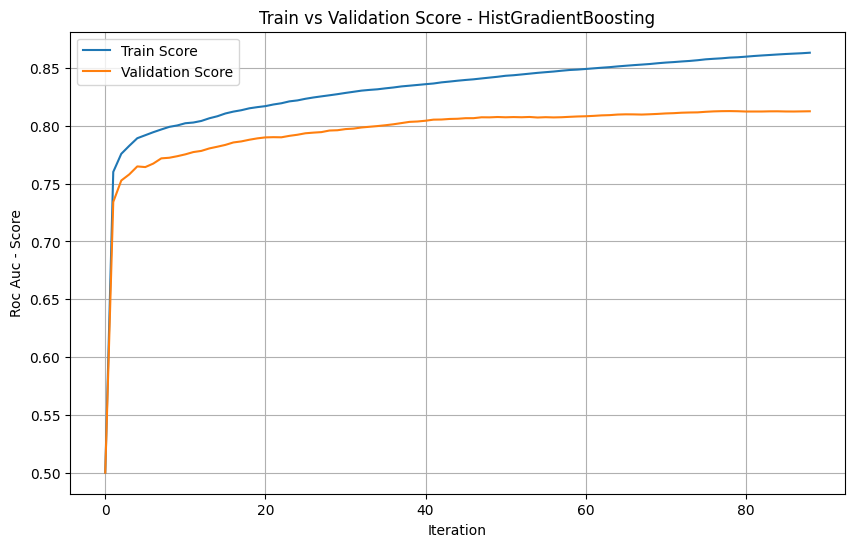

In [32]:
import matplotlib.pyplot as plt

grad = best_model.best_estimator_

plt.figure(figsize=(10, 6))
plt.plot(np.arange(0, grad.n_iter_ +1 ), grad.train_score_, label="Train Score")#, marker="o")
plt.plot(np.arange(0, grad.n_iter_ +1 ), grad.validation_score_, label="Validation Score")#, marker="s")
plt.xlabel("Iteration")
plt.ylabel("Roc Auc - Score")
plt.title("Train vs Validation Score - HistGradientBoosting")
plt.legend()
plt.grid()
plt.show()

# Random forest teamstats teamheroes + weighted average position

In [33]:
best_model.fit(df_tt_weighted,win)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
             estimator=HistGradientBoostingClassifier(max_iter=200,
                                                      random_state=42,
                                                      scoring='roc_auc',
                                                      validation_fraction=0.05),
             n_jobs=-1,
             param_grid={'l2_regularization': [0, 0.1, 0.01],
                         'max_features': [0.5, 0.75, 1.0],
                         'min_samples_leaf': [50, 60, 70]},
             refit='roc_auc', return_train_score=True,
             scoring=['roc_auc', 'accuracy', 'recall', 'precision', 'f1'],
             verbose=1)

In [34]:
best_model.cv_results_

{'mean_fit_time': array([3.09185591, 3.06491385, 3.06922112, 3.03103061, 2.96927261,
        2.84747887, 3.01166153, 3.17704558, 2.95985355, 3.28305473,
        3.32304983, 2.97709203, 3.1856329 , 3.23546696, 3.05754132,
        2.43858385, 2.85742388, 3.17545152, 3.52001047, 3.04626727,
        2.94376378, 3.33184385, 2.94827991, 3.06203542, 2.80464778,
        2.75656266, 2.93122907]),
 'std_fit_time': array([0.5826137 , 0.64851271, 0.71187691, 0.61557541, 0.8003102 ,
        0.97387755, 0.76935958, 0.86517798, 0.35420149, 0.74587305,
        0.70426104, 0.37913625, 0.30781872, 0.75473918, 0.79289811,
        0.44216582, 0.7059227 , 0.95441264, 1.13810324, 0.86935978,
        0.34532962, 0.65857275, 0.70572832, 0.56975041, 0.83398487,
        0.9986078 , 0.59937468]),
 'mean_score_time': array([0.28767991, 0.2939198 , 0.33631654, 0.34497108, 0.28723083,
        0.28173637, 0.28304572, 0.28239722, 0.30642476, 0.38254199,
        0.34471054, 0.34289432, 0.26946945, 0.32870975, 0.361430

In [35]:
cv_results:dict = best_model.cv_results_

print("Best Parameters:\n",best_model.best_params_,'\n')

results = []

for scoring in scorings:

    mean_test_roc_label = f"mean_test_{scoring}"

    mean_test_score_list = cv_results[f"mean_test_{scoring}"]

    best_test_position = np.argmin(best_model.cv_results_["rank_test_roc_auc"])

    mean_train_roc_label = f"mean_train_{scoring}"

    mean_train_score_list = cv_results[f"mean_train_{scoring}"]

    results.append({"Scoring": scoring, "Mean Test Score": mean_test_score_list[best_test_position], "Mean Train Score": mean_train_score_list[best_test_position]})

df_results = pd.DataFrame(results)

df_results

Best Parameters:
 {'l2_regularization': 0.1, 'max_features': 0.5, 'min_samples_leaf': 50} 



,Scoring,Mean Test Score,Mean Train Score
0,roc_auc,0.810007,0.876982
1,accuracy,0.722763,0.787003
2,recall,0.770134,0.828500
3,precision,0.722336,0.780861
4,f1,0.745465,0.803970


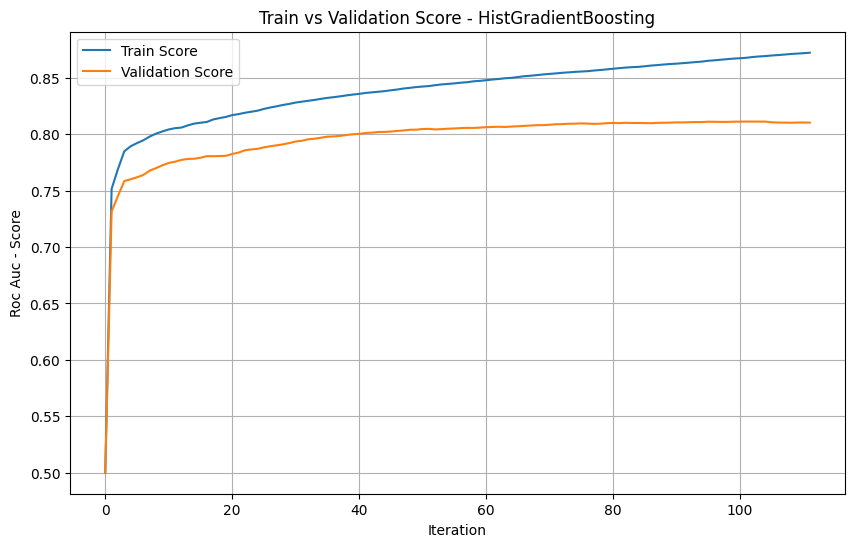

In [36]:
import matplotlib.pyplot as plt

grad = best_model.best_estimator_

plt.figure(figsize=(10, 6))
plt.plot(np.arange(0, grad.n_iter_ +1 ), grad.train_score_, label="Train Score")#, marker="o")
plt.plot(np.arange(0, grad.n_iter_ +1 ), grad.validation_score_, label="Validation Score")#, marker="s")
plt.xlabel("Iteration")
plt.ylabel("Roc Auc - Score")
plt.title("Train vs Validation Score - HistGradientBoosting")
plt.legend()
plt.grid()
plt.show()